In [1]:
import comet_ml
from comet_ml.api import API
from collections import defaultdict
import pandas as pd
import numpy as np
import os
import pickle
comet_api = API()

types = ["0", "3", "20", "23"]
energies = [
    '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
    '0.9', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'
]

In [2]:
def get_predictions_from_experiment(experiment_id):
    exp = comet_api.get("schattengenie/juno/{}".format(experiment_id))
    # get predictions
    asset_id = [a for a in exp.get_asset_list() if "datatable_predictions" in a["fileName"]][0]["assetId"]
    d = pickle.loads(exp.get_asset(asset_id), encoding='bytes')
    # first experiments were without train_type, for them default train dataset was 0
    train_type = [t for t in exp.get_parameters_summary() if "train_type" in t['name']]
    if len(train_type) == 0:
        train_type = "0"
    else:
        train_type = train_type[0]["valueCurrent"]
    return train_type, d

In [3]:
def preprocess_energy_predictions_from_comet_to_pandas(d):
    energy_predictions = defaultdict(list)

    # concatenate predictions by the network
    for energy in energies:
        for type in types:
            energy_predictions[energy].append(d[(type, energy)][:, 1])
        energy_predictions[energy] = pd.DataFrame(np.array(energy_predictions[energy]).T, columns=["pred" + t for t in types])

    # add true column
    for energy in energies:
        # true energy is the same for all types of source(or I hope so)
        energy_predictions[energy]["true"] = d[("0", energy)][:, 0]
    
    return energy_predictions

In [4]:
experiment_id = "9c2788a820594e06a837820853b35713"
train_type, d = get_predictions_from_experiment(experiment_id)
energy_predictions_0 = preprocess_energy_predictions_from_comet_to_pandas(d)
print(train_type)

0


In [5]:
experiment_id = "eb996026d81c4a72b5ac47ea3b96bc07"
train_type, d = get_predictions_from_experiment(experiment_id)
energy_predictions_23 = preprocess_energy_predictions_from_comet_to_pandas(d)
print(train_type)

23


In [6]:
experiment_id = "e77ae8632401422f90d4c836356963b4"
train_type, d = get_predictions_from_experiment(experiment_id)
energy_predictions_20 = preprocess_energy_predictions_from_comet_to_pandas(d)
print(train_type)

20


In [7]:
experiment_id = "2eab54d026a140408a4151f592789f1f"
train_type, d = get_predictions_from_experiment(experiment_id)
energy_predictions_3 = preprocess_energy_predictions_from_comet_to_pandas(d)
print(train_type)

3


In [8]:
predictions_by_train_dataset = {
    "0": energy_predictions_0,
    "23": energy_predictions_23,
    "20": energy_predictions_20,
    "3": energy_predictions_3
}

In [9]:
# save predictions for each net
for type in types:
    path = os.path.abspath("./net_trained_on_{}_edepZ".format(type))
    if not os.path.exists(os.path.expanduser(path)):
        os.mkdir(os.path.expanduser(path))
    for energy in energies:
        predictions_by_train_dataset[type][energy].to_csv(os.path.join(path, "{}MeV.csv".format(energy)), index=False)

In [10]:
# save predictions by type
path = os.path.abspath("./predictions_edepZ".format(type))
if not os.path.exists(os.path.expanduser(path)):
    os.mkdir(os.path.expanduser(path))
for energy in energies:
    predictions = []
    # append predictions
    for type in types:
        predictions.append(predictions_by_train_dataset[type][energy]["pred" + type].values)
    # append true
    predictions.append(predictions_by_train_dataset[type][energy]["true"])
    df = pd.DataFrame(np.array(predictions).T, columns=["pred" + t for t in types] + ["true"])
    df.to_csv(os.path.join(path, "{}MeV.csv".format(energy)), index=False)

In [11]:
predictions_by_train_dataset.keys()

dict_keys(['0', '23', '20', '3'])

In [12]:
summary_statistics = defaultdict(list)
types = ["0", "3", "20", "23"]
energies = [
    '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
    '0.9', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'
]

for energy in energies:
    for type in types:
        pred = predictions_by_train_dataset[type][energy]["pred" + type]
        true = predictions_by_train_dataset[type][energy]["true"]
        bias, std = ((pred - true)).mean(), np.sqrt(((pred - true)).pow(2).mean())
        summary_statistics[(type, "std")].append(std)
        summary_statistics[(type, "bias")].append(bias)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [14]:
energies = [float(e) for e in energies]

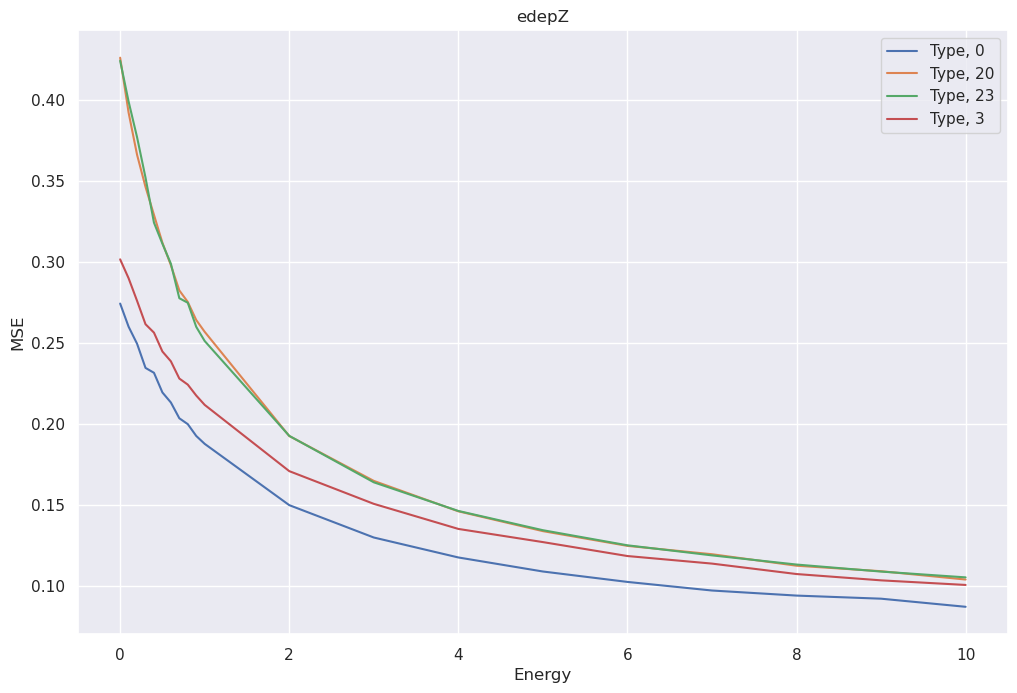

In [15]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("edepZ")
plt.xlabel("Energy")
plt.ylabel("MSE")
plt.plot(energies, summary_statistics[("0", "std")], label="Type, 0")
plt.plot(energies, summary_statistics[("20", "std")], label="Type, 20")
plt.plot(energies, summary_statistics[("23", "std")], label="Type, 23")
plt.plot(energies, summary_statistics[("3", "std")], label="Type, 3")
plt.legend()
plt.show()

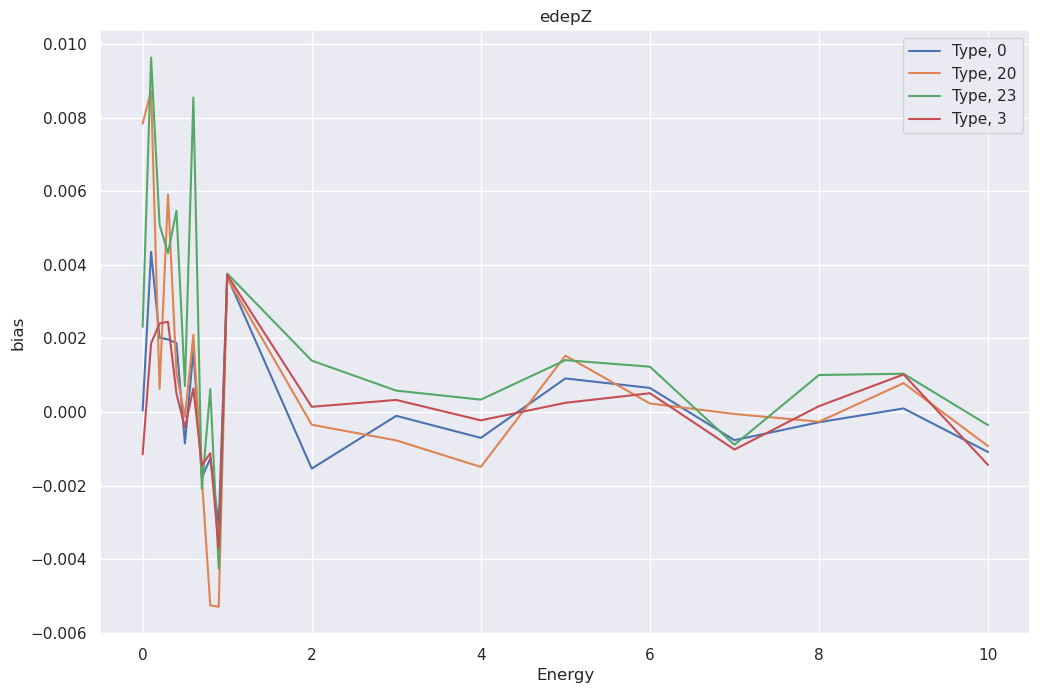

In [16]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("edepZ")
plt.xlabel("Energy")
plt.ylabel("bias")
plt.plot(energies, summary_statistics[("0", "bias")], label="Type, 0")
plt.plot(energies, summary_statistics[("20", "bias")], label="Type, 20")
plt.plot(energies, summary_statistics[("23", "bias")], label="Type, 23")
plt.plot(energies, summary_statistics[("3", "bias")], label="Type, 3")
plt.legend()
plt.show()